In [ ]:
# %pip install progressbar xgboost matplotlib boto3 openpyxl tqdm hydroeval hydrotools

In [1]:
# hydrological packages
from hydrotools.nwm_client import utils 

# my packages
from g_evaluation_metric import MAPE, RMSE, KGE, PBias
from s_evalaution_table import evtab
import s_FigureGenerator
from g_mlp_model import CustomMLP

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysi packages
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
if platform.system() == 'Windows':
    onedrive_path = 'E:/OneDrive/OneDrive - The University of Alabama/10.material/01.data/usgs_data/'
    box_path = 'C:/Users/snaserneisary/Box/NWM-ML/'

elif platform.system() == 'Darwin':
    onedrive_path = '/Users/savalan/Library/CloudStorage/OneDrive-TheUniversityofAlabama/02.projects/03.ciroh/04.data/'
    box_path = '/Users/savalan/Library/CloudStorage/Box-Box/NWM-ML/Data/NWM/ut/'
    
elif platform.system() == 'Linux':
    path_general = '/home/snaserneisary/01.projects/01.ciroh_p8/NWM-ML/Savalan/'
    path_model_save = f"{path_general}/03.output/02.mlp/03.model_parameters/best_model.pkl"
    path_save_data = f"{path_general}/03.output/02.mlp/02.data/" 
    path_save_figure = f"{path_general}/03.output/02.mlp/01.figures"

## 2. Prepare the data.

In [3]:
raw_training_data = pd.read_csv(path_general + '03.output/01.data_preparation/raw_training_data.csv')
raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305


In [4]:
Training_DF = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [5]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

#Training_DF.drop(['precipitation_in', 'temperature_F', 'Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest', 'Mean_Basin_Elev_ft'], axis=1, inplace=True)

Training_DF.drop(['Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest', 'Mean_Basin_Elev_ft'], axis=1, inplace=True)

### Remove headwater stations!!!!!!!

In [6]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
Training_DF = Training_DF[~raw_training_data['station_id'].isin(headwater_stations)]

In [7]:
Training_DF.datetime = pd.to_datetime(Training_DF.datetime)
Training_DF.head()

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
3079,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-01,9.250000,-0.891007,-0.453991,0.0,0.0,37.0,275
3080,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-02,8.654167,-0.891007,-0.453991,0.0,0.0,36.0,276
3081,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-03,9.466667,-0.891007,-0.453991,0.0,0.0,36.0,277
3082,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-04,11.833333,-0.891007,-0.453991,0.0,0.0,36.0,278
3083,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,1992-10-05,10.195833,-0.891007,-0.453991,0.0,0.0,36.0,279


### 2.1. Create the training dataset.

In [8]:
# Training is from 1980 to the end of 2015.
x_train_temp = Training_DF[Training_DF.datetime < '01-01-2015']
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp.head()

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
3079,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,37.0,275
3080,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,276
3081,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,277
3082,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,278
3083,41.57549,-111.85522,180.0,1.01,0.0653,44.2,-0.891007,-0.453991,0.0,0.0,36.0,279


#### 2.1.1. Scale the train inputs of the NN model

In [9]:
# First we need to convert it from pandas dataframe to a numpy array 
y_train = y_train_temp.to_numpy()
x_train = x_train_temp.to_numpy()
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_scaled_train.shape

(93299, 1)

In [10]:
# Convert and reshape inputs to tensors for MLP model
x_train_scaled_test = torch.Tensor(x_train_scaled)
y_train_scaled_test = torch.Tensor(y_scaled_train)
print('train x shape', x_train_scaled_test.shape)
print('train y shape', y_train_scaled_test.shape)

train x shape torch.Size([93299, 12])
train y shape torch.Size([93299, 1])


### 2.2. Create the test dataset. 

In [11]:
# Determining the test dataset. 
x_test_temp = Training_DF[Training_DF.datetime >= '01-01-2015']
x_test_temp.head()

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
10567,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2015-01-01,21.627083,-0.438371,0.898794,0.0,5.75,39.0,1
10568,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2015-01-02,23.531250,-0.438371,0.898794,0.0,5.75,39.0,2
10569,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2015-01-03,25.044792,-0.438371,0.898794,0.0,5.75,39.0,3
10570,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2015-01-04,26.103125,-0.438371,0.898794,0.0,5.75,39.0,4
10571,10105900,41.57549,-111.85522,180.0,1.01,0.0653,44.2,2015-01-05,26.742708,-0.438371,0.898794,0.0,5.75,39.0,5


#### 2.2.1. Scale the test inputs of the NN model

In [12]:
# First we need to convert it from pandas dataframe to a numpy array 
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

### 2.3. Create the validation dataset. 

In [13]:
# Create PyTorch datasets and dataloaders
X_train, X_valid, y_train, y_valid = train_test_split(x_train_scaled_test, y_train_scaled_test)

## 3. MLP Model Preparation.

### 3.1. Create the model variables.

In [14]:
model_name='MLP'
tries = 30
epochs = 100
batch_size = 365
learning_rate = 1e-4
early_stopping_patience = 0
decay = 0
neurons = 300
layer_sizes = [x_train_scaled_test.shape[1] ,128, 128, 64, 64, 32, 16, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### 3.2. Create input data.

In [15]:
train_dataset = TensorDataset(x_train_scaled_test, y_train_scaled_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = TensorDataset(X_valid, y_valid)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

### 3.3. Run and evaluate the model
Here first we train the model and then we test it.
We do it 30 times so we have firm evaluation. 

In [16]:
start_time = time.time()

# Create variables
test_best_val = float('inf')
EvalDF = {}
SupplyEvalDF = {}
EvalDF_all = np.zeros([len(station_index_list.drop_duplicates()), 10])
SupplyEvalDF_all = np.zeros([len(station_index_list.drop_duplicates()), 17])

# Start running the model several times. 
for try_number in range(1, tries+1):

    # Create the variables. 
    EvalDF[try_number] = np.zeros([len(station_index_list.drop_duplicates()), 10])
    SupplyEvalDF[try_number] = np.zeros([len(station_index_list.drop_duplicates()), 17])
    SitesDict = {}
    val_loss_all = 0
    print(f'Trial Number {try_number} ==========================================================')
    
    # Set the optimizer, create the model, and train it. 
    mlp_model = CustomMLP(layer_sizes, device)
    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate, weight_decay=decay)
    model_parameters = mlp_model.train_model(train_loader, epochs, mlp_optimizer, early_stopping_patience, path_model_save, validation_loader)
    
    # Evaluate it for different stations. 
    for station_index, station_number in enumerate(station_index_list.drop_duplicates()):
        index = station_index_list == station_number # Finind the rows that have this station number.
        temp_x_scaled_test = torch.Tensor(x_test_1_scaled)
        temp_y_scaled_test = torch.Tensor(y_scaled_test_1)
        index_np = torch.tensor(index.to_numpy())
        test_dataset = TensorDataset(temp_x_scaled_test[index_np], temp_y_scaled_test[index_np])
        test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
        
        # Evaluation
        yhat_test, val_loss = mlp_model.evaluate_model(test_loader)
        
        # Invert scaling for actual and concat it with the rest of the dataset. 
        inv_yhat_test = scaler.inverse_transform(yhat_test.cpu().numpy())
        inv_yhat_test[inv_yhat_test<0] = 0 # THIS IS NOT CORRECT !!!!!!!!!!!!!!!
        nwm_test = pd.DataFrame(inv_yhat_test, columns=['MLP_flow'])
        Dfs = [nwm_test.reset_index(drop=True), x_test_temp[index].reset_index(drop=True)]
        Eval_DF_mine = pd.concat(Dfs, axis=1)
    
        # Get reach id for model eval.
        nhdreach = utils.crosswalk(usgs_site_codes=station_number)
        nhdreach = nhdreach['nwm_feature_id'].iloc[0]
        SitesDict[nhdreach] = Eval_DF_mine
        
        # Calculate the results. 
        prediction_columns = ['NWM_flow', f"{model_name}_flow"]
        observation_column = 'flow_cfs'
        result = evtab(Eval_DF_mine, prediction_columns, nhdreach, observation_column, model_name)
        EvalDF[try_number][station_index, :] = result[0]
        SupplyEvalDF[try_number][station_index, :] = result[1]

    # Finding the best model. 
    val_loss_all += val_loss
    val_loss_all = val_loss_all / len(station_index_list.drop_duplicates())
    if val_loss_all < test_best_val:
        test_best_val = val_loss_all
        best_model_parameters = model_parameters
        best_try = try_number
        best_output = SitesDict
    EvalDF_all = EvalDF[try_number] + EvalDF_all
    SupplyEvalDF_all = SupplyEvalDF[try_number] + SupplyEvalDF_all
        
# Calculate the average results for all of the trials. 
EvalDF_all = EvalDF_all / tries
SupplyEvalDF_all = SupplyEvalDF_all / tries

# Sort the outputs of the best model based on date. 
keys = list(best_output.keys())
for key_number in keys:
    best_output[key_number] = best_output[key_number].sort_values(by='datetime')
    
print('Run is Done!' + " Run Time:" + " %s minutese " % np.round((time.time() - start_time)/60, 0))


Trial Number 1 ==========================================================
Epoch 1/100, Training Loss: 6.26624605502002e-05 Validation Loss: 0.0019354875076468335
Epoch 2/100, Training Loss: 4.4388973037712276e-05 Validation Loss: 0.0018455412729764568
Epoch 3/100, Training Loss: 6.0099038819316775e-05 Validation Loss: 0.0017799618166331342
Epoch 4/100, Training Loss: 5.465729191200808e-05 Validation Loss: 0.001706122293108066
Epoch 5/100, Training Loss: 5.6095675972756e-05 Validation Loss: 0.0016494743037829874
Epoch 6/100, Training Loss: 5.52883320779074e-05 Validation Loss: 0.001617730891855837
Epoch 7/100, Training Loss: 4.787104990100488e-05 Validation Loss: 0.0016194723335385226
Epoch 8/100, Training Loss: 3.97274452552665e-05 Validation Loss: 0.0016209669953330928
Epoch 9/100, Training Loss: 3.906749407178722e-05 Validation Loss: 0.001601426244767269
Epoch 10/100, Training Loss: 3.8783848140155897e-05 Validation Loss: 0.0015364425359538378
Epoch 11/100, Training Loss: 4.164923302

### 3.4. Create and save the final results.


In [17]:
#Evaluation columns for prediction time series
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{model_name}_rmse", 'NWM_pbias', f"{model_name}_pbias", 
        'NWM_kge', f"{model_name}__kge", 'NWM_mape',  f"{model_name}_mape"]

#Evaluation columns for accumulated supply time series
supcols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{model_name}_rmse", 'NWM_pbias', f"{model_name}_pbias", 
        'NWM_kge', f"{model_name}__kge", 'NWM_mape',  f"{model_name}_mape", 'Obs_vol', 'NWM_vol', f"{model_name}_vol",
        'NWM_vol_err', f"{model_name}_vol_err", 'NWM_vol_Perc_diff', f"{model_name}_vol_Perc_diff"]
    
#save model results
EvalDF_all = pd.DataFrame(EvalDF_all, columns=cols)
SupplyEvalDF_all = pd.DataFrame(SupplyEvalDF_all, columns=supcols)
EvalDF_all.to_csv(f"{path_save_data}/{model_name}_Performance.csv")   
SupplyEvalDF_all.to_csv(f"{path_save_data}/{model_name}_Supply_Performance.csv")
torch.save(best_model_parameters, path_model_save)

In [18]:
print("Model Performance for Daily cfs")
display(EvalDF_all)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF_all)


Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP_mape
0,10105900.0,666170.0,90.667995,93.916489,-16.13,-1.95,0.72,0.74,108.61,101.68
1,10126000.0,4605050.0,1861.439475,975.451598,-53.15,12.12,0.14,0.72,369.37,46.19
2,10129900.0,10093082.0,29.960617,8.872219,-210.87,27.72,-3.04,0.18,225.61,119.73
3,10133650.0,10276856.0,34.537693,19.137660,-135.83,33.51,-0.56,0.33,271.07,90.44
4,10133800.0,10276836.0,53.460353,29.907107,-127.58,71.36,-0.41,0.20,254.98,88.98
5,10133980.0,10276712.0,97.119345,50.497766,-179.04,80.16,-0.87,-0.01,382.65,91.38
6,10134500.0,10277268.0,128.603024,34.288353,-235.17,25.36,-1.48,0.62,1014.93,109.07
7,10136500.0,10274616.0,776.608631,330.090855,-191.07,41.25,-0.99,0.20,436.46,55.74
8,10137500.0,10274270.0,107.073089,117.011593,33.05,24.07,0.48,0.44,38.66,80.02
9,10140100.0,10275828.0,270.370388,214.047804,-134.83,13.42,-0.42,0.35,813.07,192.39


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP_mape,Obs_vol,NWM_vol,MLP_vol,NWM_vol_err,MLP_vol_err,NWM_vol_Perc_diff,MLP_vol_Perc_diff
0,10105900.0,666170.0,1.432436e+04,17769.319393,-2.92,-6.28,0.78,0.76,27.83,52.70,37232.679662,50915.508,55964.527344,1.368283e+04,18731.847682,36.749513,50.310232
1,10126000.0,4605050.0,3.522460e+05,151728.843657,-28.50,12.00,0.46,0.87,50.06,26.62,655183.188796,1149487.593,541260.687500,4.943044e+05,-113922.501296,75.445221,-17.387885
2,10129900.0,10093082.0,8.093940e+03,1630.717047,-219.00,33.62,-2.08,0.53,220.63,52.98,3759.072756,18822.636,3863.502930,1.506356e+04,104.430174,400.725504,2.778083
3,10133650.0,10276856.0,9.281958e+03,2547.633026,-94.33,24.69,-0.30,0.74,105.73,49.12,9663.116575,30161.430,6767.207031,2.049831e+04,-2895.909543,212.129423,-29.968691
4,10133800.0,10276836.0,1.579701e+04,10192.729543,-93.53,67.84,-0.30,0.16,108.76,78.63,18057.498883,47800.215,5105.713379,2.974272e+04,-12951.785504,164.711161,-71.725246
5,10133980.0,10276712.0,3.113292e+04,18089.095099,-133.03,78.69,-0.73,-0.06,155.75,85.10,23337.537876,78025.101,5601.339355,5.468756e+04,-17736.198521,234.333045,-75.998585
6,10134500.0,10277268.0,4.855101e+04,4864.413903,-279.98,16.70,-2.35,0.81,876.92,44.83,37262.276126,96970.683,27591.066406,5.970841e+04,-9671.209719,160.238217,-25.954426
7,10136500.0,10274616.0,2.882531e+05,100820.405423,-171.96,43.56,-0.99,0.27,359.13,44.53,172949.053299,490788.534,109404.625000,3.178395e+05,-63544.428299,183.776363,-36.741703
8,10137500.0,10274270.0,2.471682e+04,29319.626998,39.60,26.86,0.54,0.48,41.05,45.26,54744.014371,39350.652,54603.828125,-1.539336e+04,-140.186246,-28.118804,-0.256076
9,10140100.0,10275828.0,6.143533e+04,39065.364763,-95.65,20.14,-0.01,0.51,535.25,106.24,28156.377964,119525.325,52653.667969,9.136895e+04,24497.290005,324.505329,87.004408


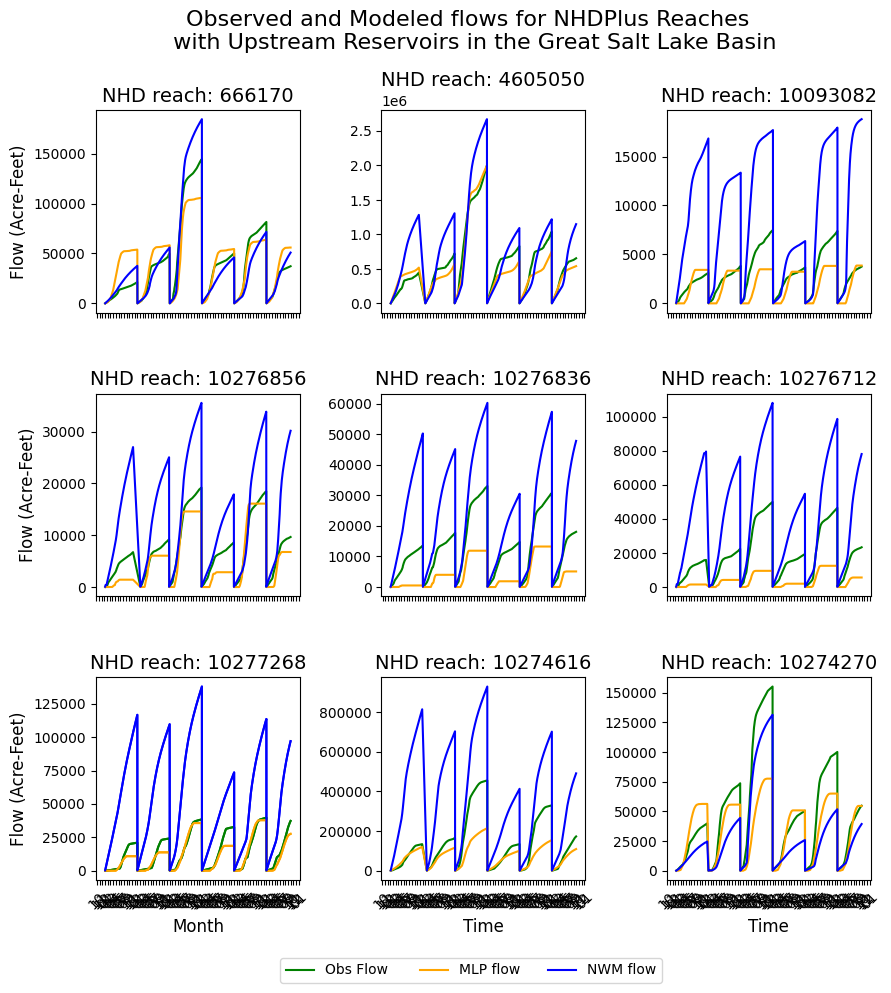

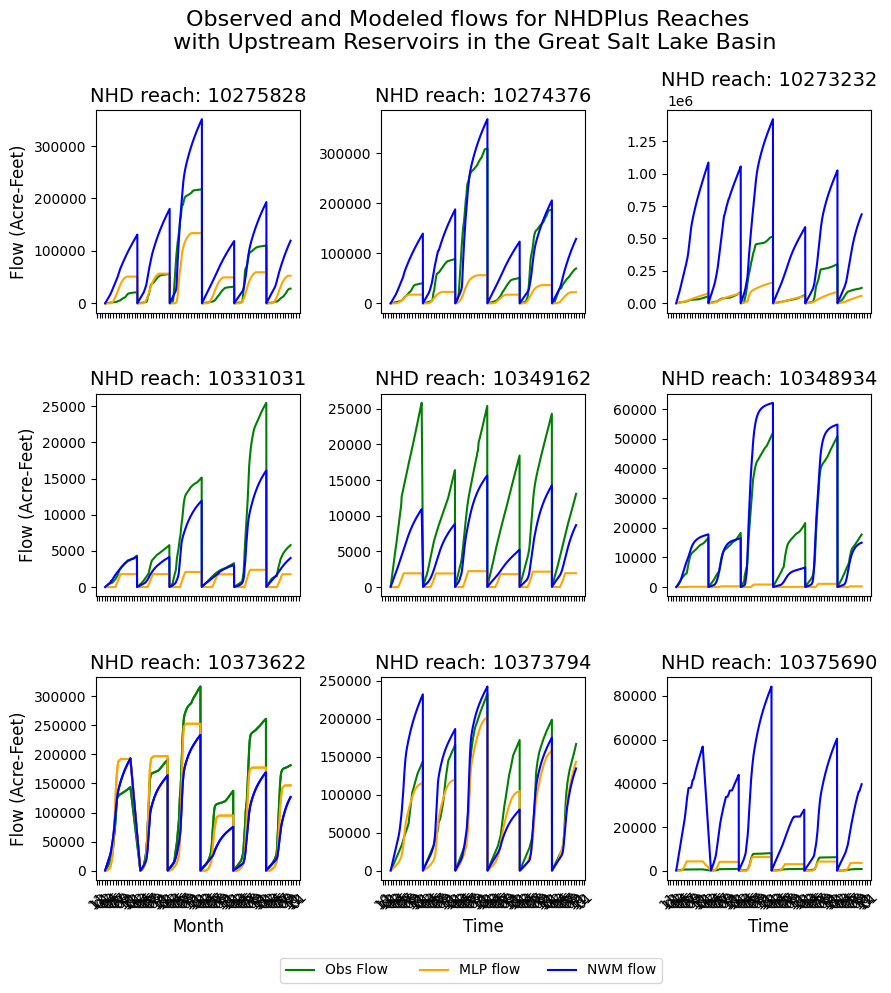

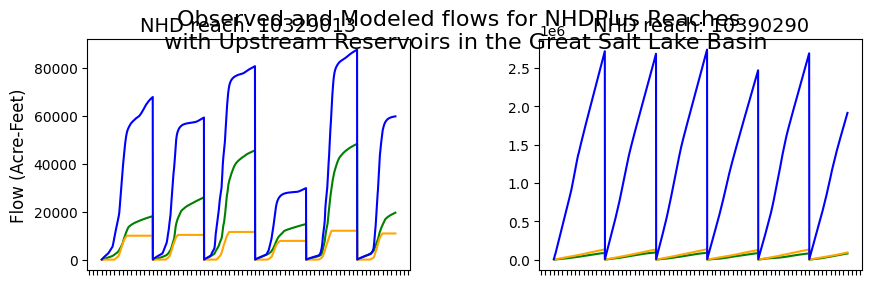

In [19]:
%load_ext autoreload
%autoreload
import s_FigureGenerator    
plotname = 'MLP_TS_plot'
freq = 'D'
supply = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
path_figure_1 = f"{path_save_figure}/{plotname}"
s_FigureGenerator.TS_plot(best_output, model_name, path_figure_1, title, freq, supply)

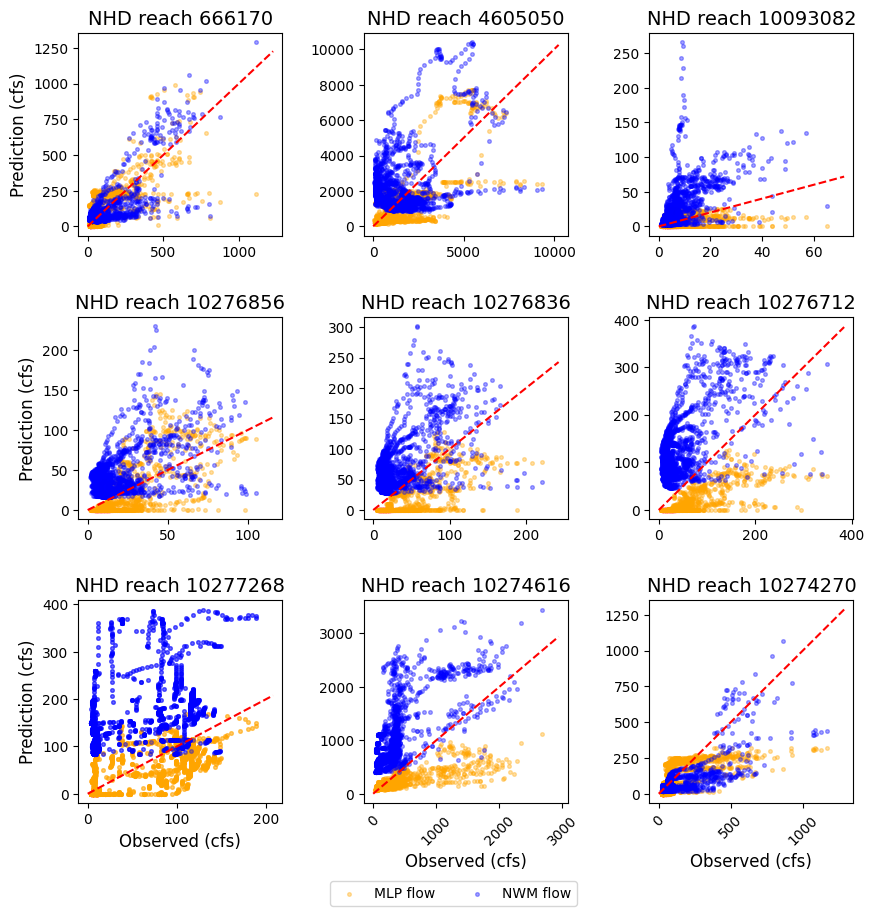

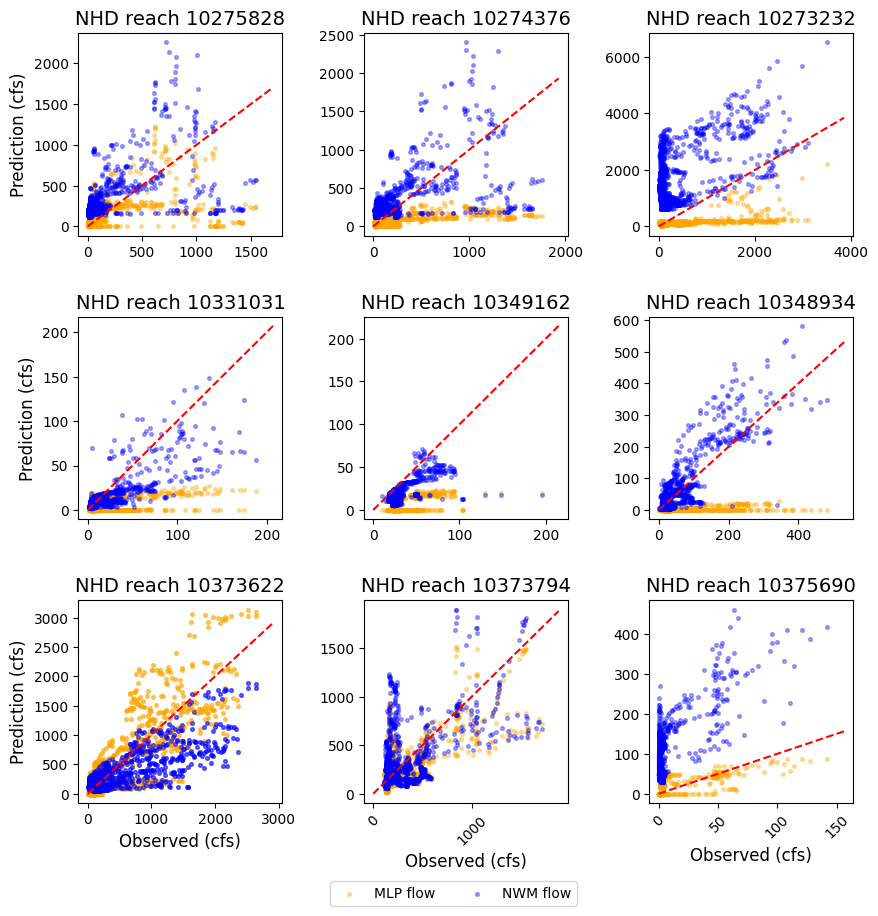

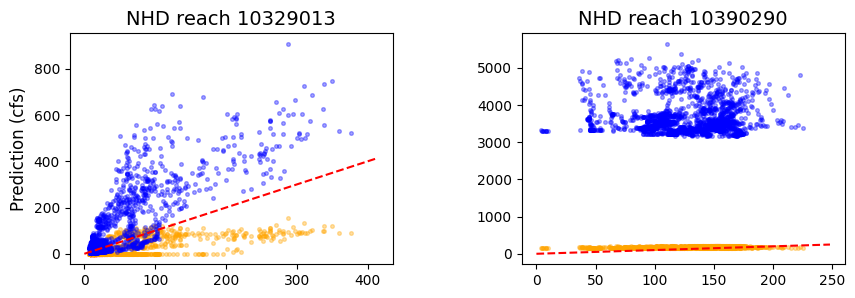

In [20]:
plotname = 'MLP_ParityPlot'
path_figure_2 = f"{path_save_figure}/{plotname}"
s_FigureGenerator.Parity_plot(best_output, model_name, path_figure_2)

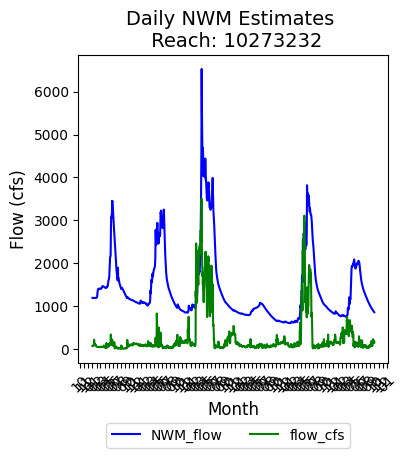

In [21]:
reach = 10273232
variables =['NWM_flow', 'flow_cfs']
colors = ['blue', 'green']
plotname = 'NWMFlow'
path_figure_3 = f"{path_save_figure}/{plotname}.png"
units = 'cfs'
y_lab = f"Flow ({units})"
title = f"Daily NWM Estimates \n Reach: {str(reach)}"

s_FigureGenerator.Var_TS_plot(best_output, reach, variables, colors, model_name,y_lab, path_figure_3, title, units, supply = False)

In [ ]:
import AWS_transfer
state = 'ut'
AWS_transfer.Predictions2AWS(model_name, state)